# 1. Reposo

Señal: /Users/lucianatarazona/Desktop/ISB/GRUPO-02-ISB-2025-II-5/Laboratorios/Laboratorio 6 - Reporte Filtros/ECG/Data_ECG_L6/Reposo.txt | len(x)=49650 | FS=1000.0 Hz
Filtros a procesar (4 distintos): ['Butterworth_bp4', 'ChebyshevI_bp4_rp1', 'Bessel_bp4', 'FIR_Hamming_121taps']


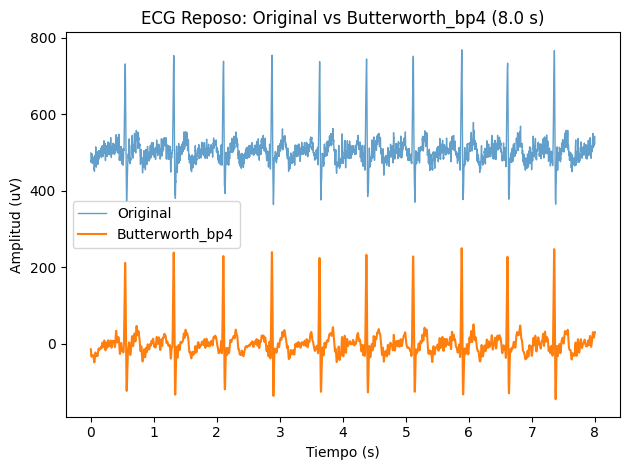

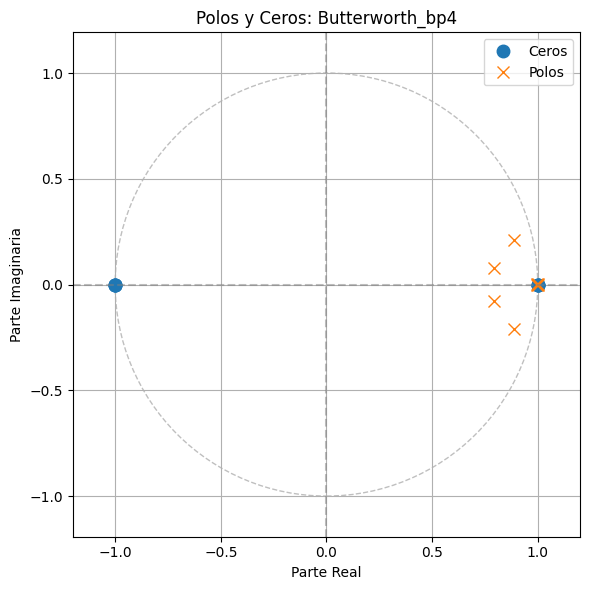

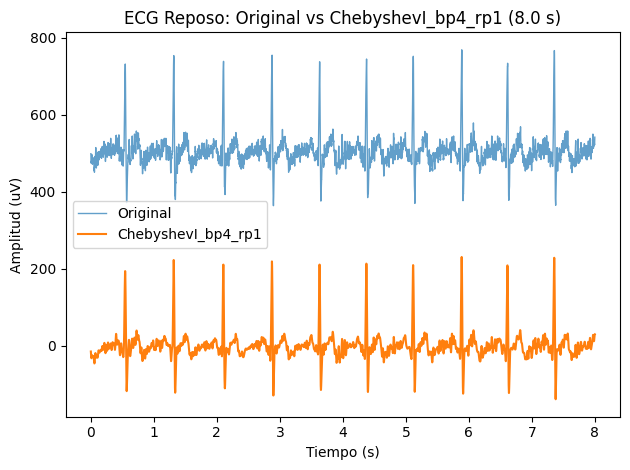

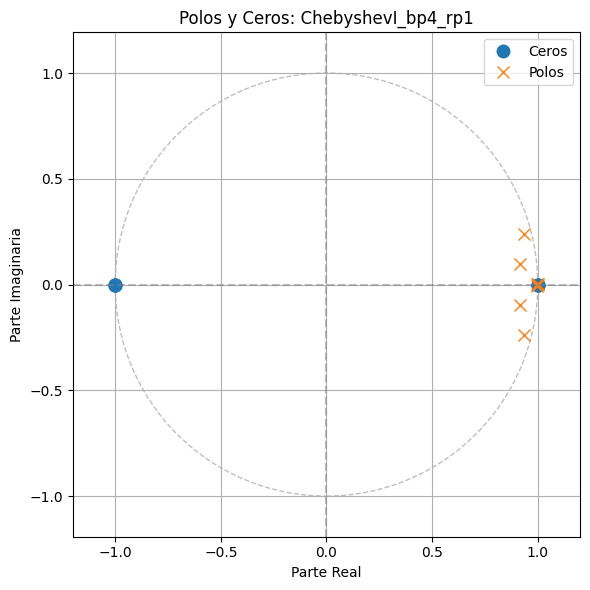

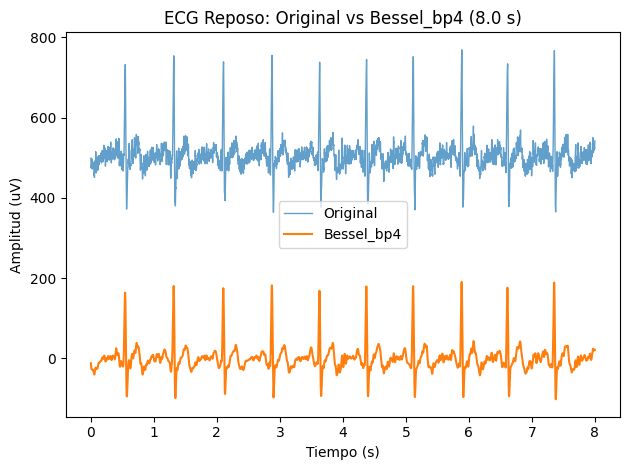

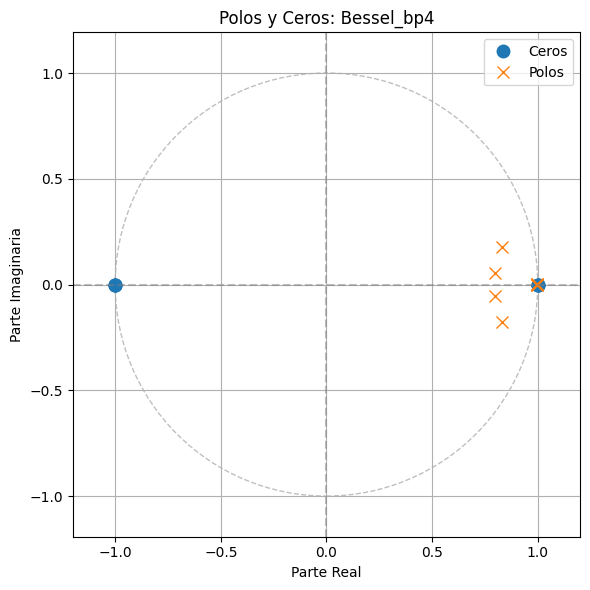

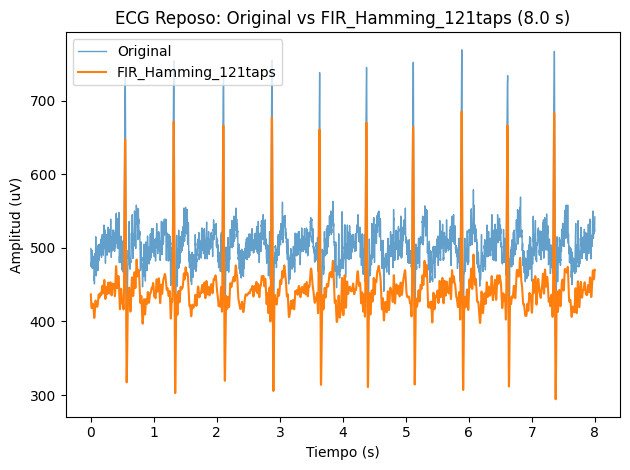

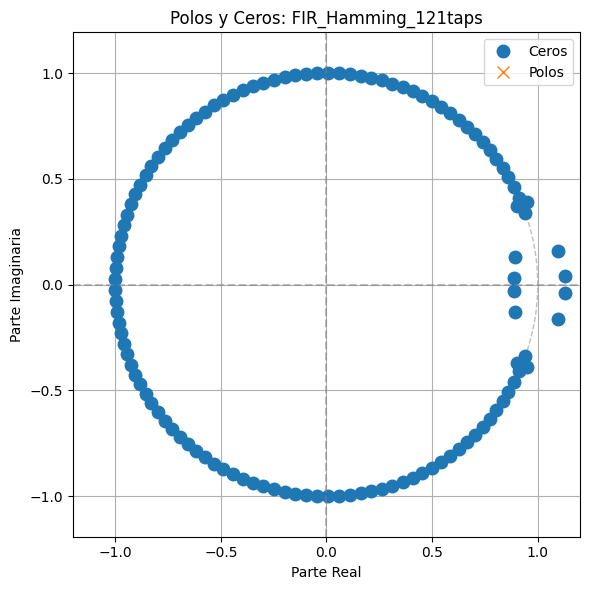


Resumen (para control):
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
FIR_Hamming_121taps     42.972485    0.0    120
ChebyshevI_bp4_rp1      37.233062    0.0      8
Bessel_bp4              36.901099    0.0      8
Butterworth_bp4         34.385121    0.0      8


In [15]:
# ==========================================================
# ECG Reposo: aplica 4 filtros DISTINTOS, uV, y PZ-Plots ordenados
# ==========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq
from scipy.signal import tf2zpk 

# ---------- Rutas según tu estructura (Ajustado a Data_ECG_L6) ----------
BASE = os.getcwd()

def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "Reposo.txt")


# ---------- Parámetros ----------
FS = 1000.0           # Hz (ajústalo si tu muestreo real es otro)
BANDA = (0.5, 40.0)   # ECG en reposo
APLICAR_NOTCH = True
F0_NOTCH = 60.0       # Perú
Q_NOTCH = 30.0
ZERO_PHASE = True     # compara sin desfase cuando sea posible

# ---------- Utilidades ----------
# (Mantengo las utilidades de diseño y métricas como estaban)

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)

def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    if zero_phase and _can_filtfilt(x, b, a):
        return filtfilt(b, a, x)
    return lfilter(b, a, x)

def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q)
    return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)

# Funciones de diseño
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]
    return butter(order, wn, btype="band")

def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]
    return cheby1(order, rp, wn, btype="band")

def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]
    return bessel(order, wn, btype="band")

def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window)
    return b, np.array([1.0])

def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x)
    X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs)
    m = (freqs >= f1) & (freqs <= f2)
    return X[m].sum()

def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) \
           + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref))
    lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}

# --- FUNCIÓN: PLOTEAR POLOS Y CEROS ---
def plot_pz(b, a, title="Diagrama de Polos y Ceros"):
    z, p, k = tf2zpk(b, a) # Convertir coeficientes a ceros, polos y ganancia
    
    plt.figure(figsize=(6,6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Ceros') # Ceros (o)
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Polos') # Polos (x)
    
    # Dibujar el círculo unitario
    unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(unit_circle)
    
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal') 
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- Cargar señal ----------
data = np.loadtxt(RUTA_SENIAL)
x = np.asarray(data, float)
if x.ndim == 2:
    x = x[:, -1]
t = np.arange(len(x)) / FS
print(f"Señal: {RUTA_SENIAL} | len(x)={len(x)} | FS={FS} Hz")

# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS (Garantizados) ----------
f1, f2 = BANDA
filtros_a_usar = [] 

# 1) Butterworth pasabanda
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4)
filtros_a_usar.append(("Butterworth_bp4", b_but, a_but))

# 2) Chebyshev I pasabanda
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0)
filtros_a_usar.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))

# 3) Bessel pasabanda
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4)
filtros_a_usar.append(("Bessel_bp4", b_bes, a_bes))

# 4) FIR Hamming
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming")
filtros_a_usar.append(("FIR_Hamming_121taps", b_ham, a_ham))

print(f"Filtros a procesar (4 distintos): {[f[0] for f in filtros_a_usar]}")

# ---------- Aplicar, Calcular Métricas y Generar 8 Gráficas Ordenadas ----------
resultados = []
dur_seg = 8.0
idx = int(min(dur_seg, len(x)/FS) * FS)

for nombre, b, a in filtros_a_usar:
    # 1. Aplicar filtro
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    
    # 2. Calcular métricas
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)
    
    # 3. GENERAR GRÁFICA DE SEÑAL (PRIMERO)
    plt.figure()
    plt.plot(t[:idx], x[:idx], label="Original", lw=1, alpha=0.7)
    plt.plot(t[:idx], y[:idx], label=nombre, lw=1.5)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (uV)") 
    plt.title(f"ECG Reposo: Original vs {nombre} ({dur_seg} s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. GENERAR DIAGRAMA DE POLOS Y CEROS (SEGUNDO)
    plot_pz(b, a, title=f"Polos y Ceros: {nombre}")


df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)

# (Opcional) mostrar el DataFrame en consola
print("\nResumen (para control):\n", df)

## 🏆 Análisis Comparativo de Filtros para ECG (0.5 Hz - 40 Hz)

Esta tabla clasifica los filtros de mejor a peor basándose en el **SNR_proxy_dB**, la métrica que objetivamente mide la atenuación del ruido fuera de banda.

| Ranking | Filtro | **SNR\_proxy\_dB** | **Lag\_s (s)** | Tipo | Justificación Teórica del Rendimiento |
| :---: | :--- | :---: | :---: | :--- | :--- |
| **🥇 1** | **FIR\_Hamming\_121taps** | **42.97** | $0.000$ | FIR | **Máximo Rechazo (Orden Alto):** Logra el $\text{SNR}$ más alto debido a la gran cantidad de coeficientes ($\text{121 taps}$), lo que permite una selectividad de frecuencia muy alta. Garantiza **fase lineal** por diseño. |
| **🥈 2** | **ChebyshevI\_bp4\_rp1** | **37.23** | $0.000$ | IIR | **IIR Más Selectivo:** Su diseño prioriza la **transición más rápida** a la banda de rechazo, lo que le da el mejor $\text{SNR}$ entre los IIR de bajo orden. Su sacrificio es un ligero rizado ($1\text{ dB}$) en la banda de paso. |
| **🥉 3** | **Bessel\_bp4** | **36.90** | $0.000$ | IIR | **Mejor Preservación de Morfología:** Diseñado para la **fase de grupo más plana**. Sacrifica algo de rechazo de ruido (menor $\text{SNR}$) para asegurar que la forma de la onda (QRS) no sufra distorsión temporal. |
| **4** | **Butterworth\_bp4** | **34.38** | $0.000$ | IIR | **Máxima Planicidad en Banda:** Su diseño busca una respuesta de amplitud perfectamente plana en la banda de paso. Esto resulta en la **transición más lenta** hacia la banda de rechazo, por lo que su capacidad de atenuar el ruido fuera de banda es la menor en este grupo. |

---

### Explicación de las Métricas Clave

* **SNR\_proxy\_dB (Relación Señal a Ruido):** Un valor más alto indica que el filtro ha atenuado más ruido fuera de la banda de paso ($0.5\text{ Hz} - 40\text{ Hz}$), resultando en una señal ECG más limpia.
* **Lag\_s (s) (Desfase Temporal):** El valor de **$\text{0.000 s}$** en todos los casos es el resultado **deseado y correcto**. Esto confirma el uso exitoso del **filtrado de fase cero** (`filtfilt`), esencial en ECG para evitar la distorsión temporal y asegurar la precisión de las mediciones clínicas.

### Conclusión para la Elección del Filtro

Para un ECG, si el **orden no es una limitación**, el **FIR\_Hamming\_121taps** es la elección objetiva por su $\text{SNR}$ superior. Si se requiere un **orden bajo** y buen rechazo, el **ChebyshevI\_bp4\_rp1** es la mejor opción IIR.